In [87]:
# importing MNIST DATASET
# to enable plotting in Jupyter notebooks.
%pylab inline
import torch
from torchvision import datasets, transforms

# loading MNIST dataset for training, if not already downloaded
TRAIN_DATA_SET = datasets.MNIST('../data', train=True, download=True,
                   # applying transformations to the dataset
                   transform=transforms.Compose([
                       transforms.ToTensor(),  # converting images to tensors
                       transforms.Normalize((0.1307,), (0.3081,))  # normalizing the images
                   ]))

# converting the training labels of the MNIST dataset to NumPy array
train_labels = TRAIN_DATA_SET.train_labels.numpy()

# converting the training data of the MNIST dataset to NumPy array
train_data = TRAIN_DATA_SET.train_data.numpy()

# Flattening the training data as EM algorithm works with flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


In [88]:
# binarize to convert the (flattened MNIST data to binary images)
# each pixel x_i is between {0,1}
def binarize(X):
    return 1. * (X >= 0.5)

In [89]:
#  Binarizing the training data
BINARIZ_TRAINED_DATA = binarize(train_data)

# Asserting that the dtype of binarized data is float
assert BINARIZ_TRAINED_DATA.dtype == float

# Asserting that the shape of binarized data is the same as the original data
assert BINARIZ_TRAINED_DATA.shape == train_data.shape


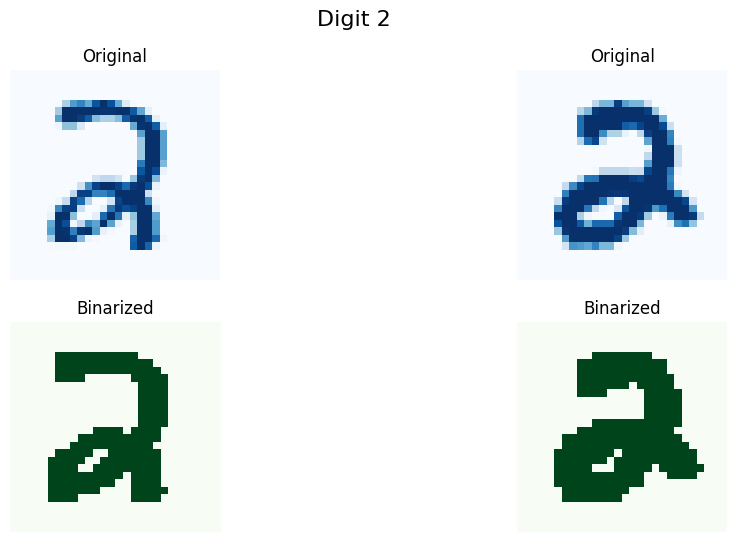

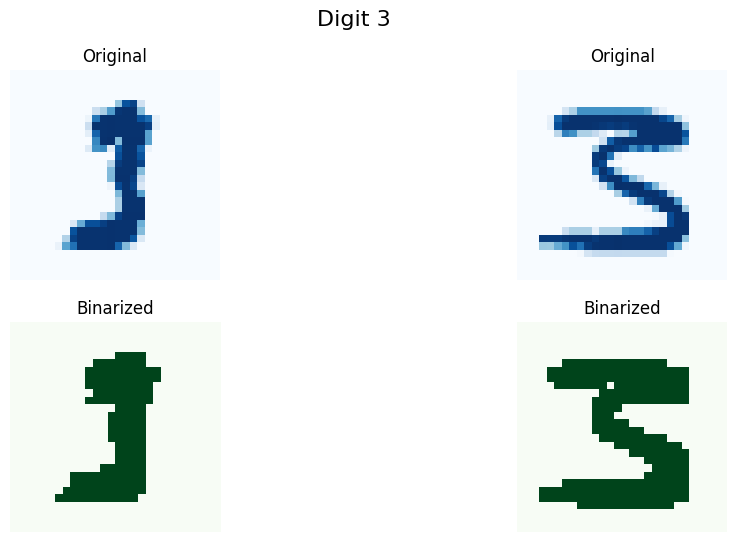

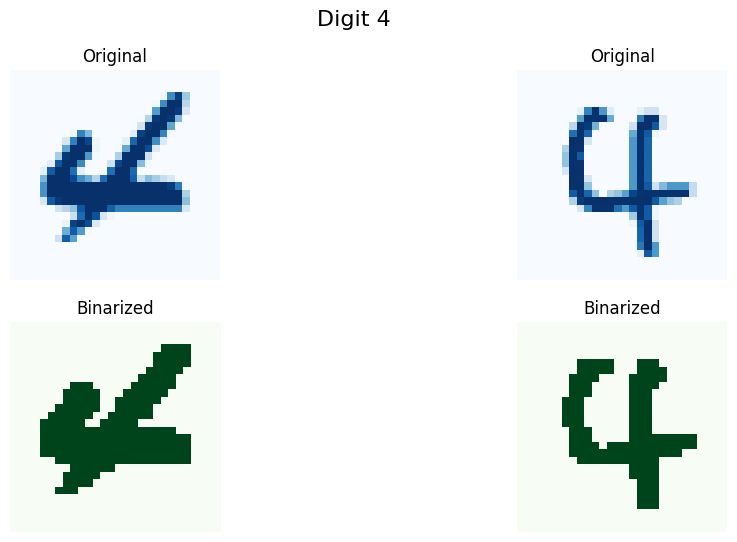

In [90]:
# this function for -->
#  visualize original and binarized digits from the MNIST dataset.

def visualize_digit(digit, n_samples=2):
    idxs = np.random.choice(np.where(train_labels == digit)[0], n_samples)
    fig, ax = plt.subplots(nrows=2, ncols=n_samples, figsize=(12, 6))

    for i, idx in enumerate(idxs):
        img = train_data[idx].reshape(28, 28) # 28 x 28
        bin_img = binarize(img)
        ax[0, i].imshow(img, cmap='Blues')  # Original image in blue
        ax[0, i].set_title("Original", fontsize=12)
        ax[0, i].axis('off')
        ax[1, i].imshow(bin_img, cmap='Greens')  # Binarized image in green
        ax[1, i].set_title("Binarized", fontsize=12)
        ax[1, i].axis('off')

    plt.suptitle(f'Digit {digit}', fontsize=16)
    plt.show()

for digit in [2, 3, 4]:
    visualize_digit(digit)



In [93]:
# implementinh E step of the EM algoritham
# it calculates the posterior probability of each data point belonging to each cluster
def E_step(X, mu, pi):
    eps = 1e-10 # for stability in log operations
    gamma = np.exp(np.log(pi+eps) + X @ np.log(mu.T+eps) + (1 - X) @ np.log(1 - mu.T + eps))
    gamma  /= gamma.sum(axis=1)[:, np.newaxis]
    return gamma


In [94]:
n_test = 5
X_test = BINARIZ_TRAINED_DATA[:n_test]  # Taking the first 5 datapoints for testing
D_test, K_test = X_test.shape[1], 10  # Getting the dimensions of the test data and number of clusters

# Initializing random values for means (mu) and uniform values for mixing coefficients (pi)
np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test, D_test))
pi_test = np.ones(K_test) / K_test

# Performing the E-step to compute the posterior probabilities (gamma) for the test data
gamma_test = E_step(X_test, mu_test, pi_test)

# Asserting that the shape of gamma_test is as expected
assert gamma_test.shape == (n_test, K_test)


In [95]:
# M-step of the EM algorithm
def M_step(X, gamma):
    # Summing up the posterior probabilities (gamma) for each cluster
    N_m = gamma.sum(axis=0)

    # Updating the mixing coefficients (pi) by dividing the total number of points in each cluster by the total number of points
    pi = N_m / X.shape[0]

    # Computing the weighted average of the data points for each cluster to update the means (mu)
    # Transposing gamma to have cluster-wise sums, then multiplying with X and dividing by the cluster sums
    mu = gamma.T @ X / N_m[:, np.newaxis]

    return mu, pi  # Returning the updated means (mu) and mixing coefficients (pi)


In [96]:
# Computing the updated means (mu_test) and mixing coefficients (pi_test) using the M-step function
mu_test, pi_test = M_step(X_test, gamma_test)

# Asserting that the shape of mu_test matches the expected shape (number of clusters by number of dimensions)
assert mu_test.shape == (K_test, D_test)

# Asserting that the shape of pi_test matches the expected shape (number of clusters)
assert pi_test.shape == (K_test, )


In [97]:
#  EM ALGORITHAM
#  Ireratively performs E-step and M-step until convergence or a maximum number of iterations

def EM(X, K, max_iter, threshold=1e-3, mu=None, pi=None):
    # Check if initial means (mu) and mixing coefficients (pi) are provided, otherwise initialize them randomly
    if mu is None:
        mu = np.random.uniform(low=.15, high=.85, size=(K, shape(X)[1]))  # Random initialization of means
    if pi is None:
        pi = np.ones(K) / K  # Uniform initialization of mixing coefficients

    # Loop for the maximum number of iterations
    for i in range(1, max_iter+1):
        # Store the old values of means and mixing coefficients for convergence checking
        mu_old, pi_old = mu, pi

        # Perform E-step to compute posterior probabilities (gamma)
        gamma = E_step(X, mu, pi)

        # Perform M-step to update means and mixing coefficients
        mu, pi = M_step(X, gamma)

        # Compute the change in means and mixing coefficients from the previous iteration
        delta_mu, delta_pi = np.linalg.norm(mu-mu_old), np.linalg.norm(pi-pi_old)

        # Print progress every 10 iterations
        if i % 10 == 0:
            print('Iterations [{:4d}/{:4d}] | DELTA : {:6.4f} | DELTA pi: {:6.4f}'.format(
                i, max_iter, delta_mu, delta_pi))

        # Check for convergence based on the specified threshold
        if delta_mu < threshold and delta_pi < threshold:
            print("\n COVERGED AT ITERATION {}.".format(i))
            return gamma, mu, pi

    # Return the computed posterior probabilities, means, and mixing coefficients
    return gamma, mu, pi



------------------------------------------------------------\ TRAINING EM ON LABELS [2, 3, 4] AND NUMBER OF CLUSTERS K = 3
------------------------------------------------------------

TRUE MIXING COEFFICIENT [0.33227372 0.34192181 0.32580447]

 TRAINING PROGRESS
Iterations [  10/ 100] | DELTA : 0.0068 | DELTA pi: 0.0005

 COVERGED AT ITERATION 15.


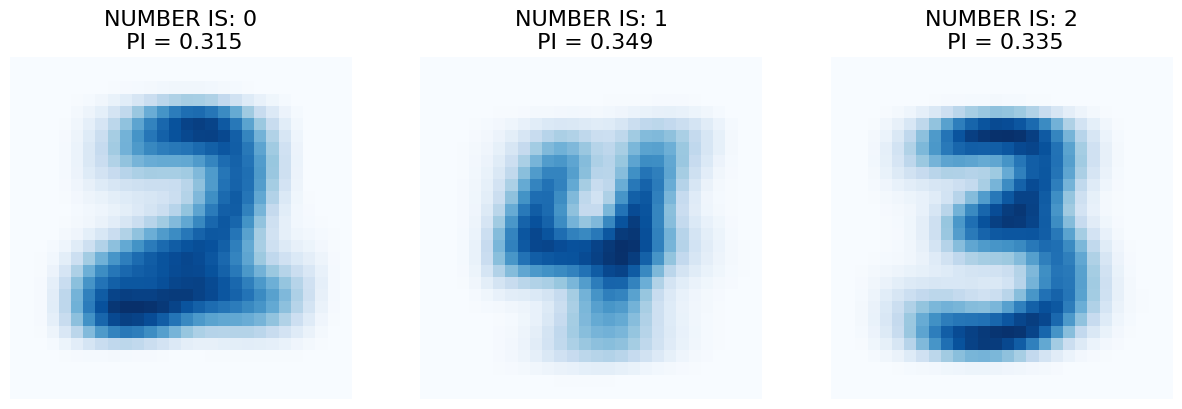

In [86]:
# this function is main entry point.
# It takes a list of digits to cluster, along with other optional parameters like the number of clusters (K)
#  number of epochs (iterations), and whether to initialize mixing coefficients with true values
# Running your EM algorithm and showing the reconstructed digits.

def sample_labels(labels, epochs=100, K=None, mu=None, pi=None, true_pi_init=False):
    # Set the number of clusters (K) to the number of unique labels if not provided
    if K is None: K = len(labels)

    # Print header for training information
    print('-'*60+'\ TRAINING EM ON LABELS {} AND NUMBER OF CLUSTERS K = {}\n'.format(labels, K)+'-'*60+'\n')

    # Get the indices of the training data corresponding to the specified labels
    labels_idxs = np.isin(train_labels, labels)

    # Extract subset of training labels and data based on the specified labels
    subset_train_labels = train_labels[labels_idxs]
    subset_train_data = BINARIZ_TRAINED_DATA[labels_idxs]

    # Compute true mixing coefficients (pi_true) based on the specified labels
    pi_true = []
    for label in labels:
        n_labels = np.isin(train_labels, label)
        pi_true.append(n_labels.sum())
    print('TRUE MIXING COEFFICIENT {}'.format(np.array(pi_true)/np.array(pi_true).sum()))

    # If true_pi_init is True, initialize mixing coefficients (pi) with pi_true
    if true_pi_init: pi = np.array(pi_true)

    # Print training progress information
    print('\n TRAINING PROGRESS')

    # Perform Expectation-Maximization (EM) algorithm on the subset of data
    gamma, mu, pi = EM(X=subset_train_data, K=K, max_iter=epochs, mu=mu, pi=pi)

    # Visualize the learned parameters (mu) for each cluster
    fig, ax = plt.subplots(nrows=1, ncols=K, figsize=(15, 15), dpi=100)
    for i in range(K):
        ax[i].imshow(mu[i].reshape(28,28), cmap='Blues')
        ax[i].set_title('NUMBER IS: {}\n PI = {:0.3f}'.format(i, pi[i]), fontsize=K**(-1)//0.02)
        ax[i].axis('off')
    plt.show()

# Sample the specified labels [2, 3, 4]
sample_labels([2,3,4])
